# Organization of the notebook and information about the problem

The main objective of this project is to train a set of models for supervised classification of neural states in mice. Over the last 15 years, the amount and quality of data associated with this problem have been growing, presenting the opportunity to train machine learning models to classify these neural states. In a typical experiment, mice are subjected to visual stimuli while running on a treadmill, and their neural activity is recorded, in this case using optogenetic techniques in the visual cortex.

The pre-processed data are acquired from a 2018 paper:

[Carsen Stringer, Marius Pachitariu, Nicholas Steinmetz, Charu Bai Reddy, Matteo Carandini, Kenneth D. Harris. "Spontaneous behaviors drive multidimensional, brain-wide population activity."](https://www.biorxiv.org/content/10.1101/306019v2)

The code for data acquisition can be found at: [GitHub](https://github.com/MouseLand/stringer-pachitariu-et-al-2018a)

### Schematic of the data acquisition process used in the paper
![drawing](images/data_capture.png)

Basically, the data is a matrix that records the activity of a given neuron (for this experiment, $N = 13101$ neurons in the visual cortex) at a given time (e.g., a frame). The data is sampled at approximately 30 Hz but also contains a vector that indicates if the mouse was being stimulated by the screen or not. The neurons were recorded from 11 different planes, but we are not considering the spatial dimensions of the data for this project, only the index of the neuron.

## What do I want to predict?

In the mentioned paper, they discovered that the spontaneous activity (without stimulus) and the stimulated activity exist in separate high-dimensional manifolds that are loosely orthogonal. Therefore, my question was: given only the activity pattern at a given frame, is there a way to predict if the mouse was looking at a picture or not, in other words, if it was stimulated or just seeing a black background? To attempt this, I experimented with several supervised learning algorithms and analyzed their performance.

## Organization of the notebook

0) Data inspection 
1) Class Balancing using Random Undersampling and construction of the train and test datasets
2) Training a Bayes Classifier using the mean activity of the neurons in a given frame
3) Dimensionality Reduction of the full dataset using PCA
4) Training Logistic Regression on the PCA components
5) Training KNN Classification on the PCA components
6) Training a Deep Neural Network model
7) Conclusions and future improvements



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
import os
import scipy.io as sio
from scipy import interpolate

import sklearn

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import RocCurveDisplay, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

## 0) Data Inspection

All the data is contained in .mat file (matlab object file), in this case we only using the data from one mouse and ignoring the spatial coordinates of the neurons

In [2]:
"""
Download data (this could take some minutes dependending on your internet speed)
"""
import urllib.request
urllib.request.urlretrieve("https://figshare.com/ndownloader/files/11492258", "data/stimspont_M170714_MP032_20170801.mat")



('data/stimspont_M170714_MP032_20170801.mat',
 <http.client.HTTPMessage at 0x7cef61fb5550>)

In [3]:
mt = sio.loadmat('data/stimspont_M170714_MP032_20170801.mat')
spks = mt["Fsp"]                 # activity of neurons by timepoints
med = mt["med"]                  # cell centers (X Y Z)
is_stimulus = mt["stimtpt"]      # vector that stores the stimulus times

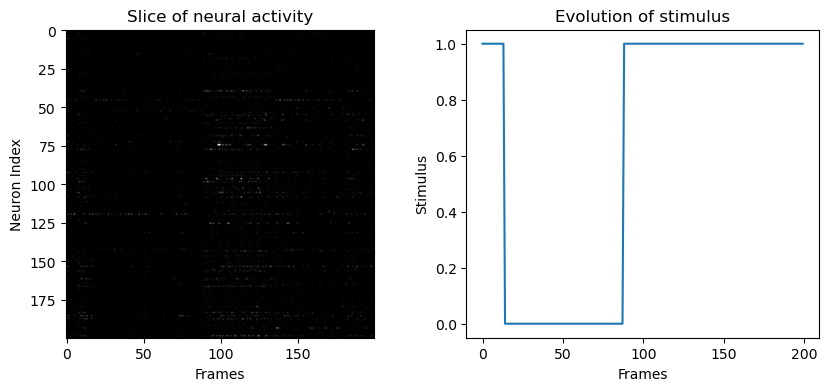

In [4]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4))
ax1.imshow(spks[:200, :200], cmap = "gray")
ax1.set_xlabel("Frames")
ax1.set_ylabel("Neuron Index")
#ax1.colorbar()
ax1.set_title("Slice of neural activity")

ax2.plot(is_stimulus[:200])
ax2.set_xlabel("Frames")
ax2.set_ylabel("Stimulus")
ax2.set_title("Evolution of stimulus")

plt.show()

In [5]:
# Get the dimensions of the spikes matrix
N_neurons, N_frames = spks.shape

# Transpose the spikes matrix to get a matrix of the type (N_frames, N_neurons)
# where every neuron is a feature
X = spks.T

# Initialize an array to store the labels
y = np.zeros(N_frames)

# Iterate over each frame to assign the labels
for i in range(N_frames):
    # Assign the label based on whether there was a stimulus at that frame
    y[i] = is_stimulus[i][0]


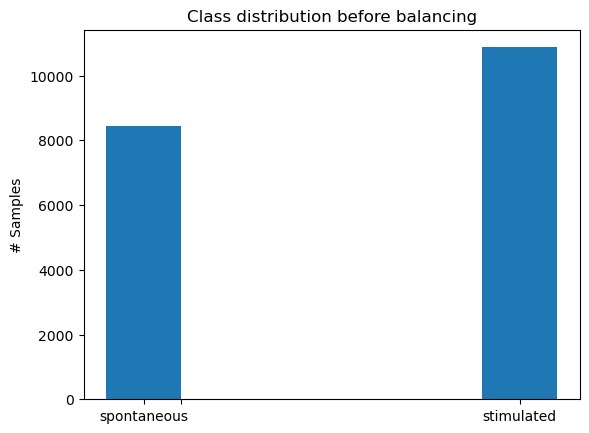

In [6]:
plt.hist(y, bins=[-0.1, 0.1, 0.9,1.1])
plt.xticks([0,0.1,1.0],['spontaneous', '', 'stimulated'])
plt.ylabel("# Samples")
plt.title("Class distribution before balancing")
plt.show()

## 1) Class Balancing and dataset construction

As we saw in the histogram the dataset is not balanced so we use a Random Undersampler to build a new balanced dataset

In [7]:
from imblearn.under_sampling import RandomUnderSampler

# Initialize RandomUnderSampler with a specific random state for reproducibility
rus = RandomUnderSampler(random_state=42)

# Resample the data using RandomUnderSampler
X_res, y_res = rus.fit_resample(X, y)

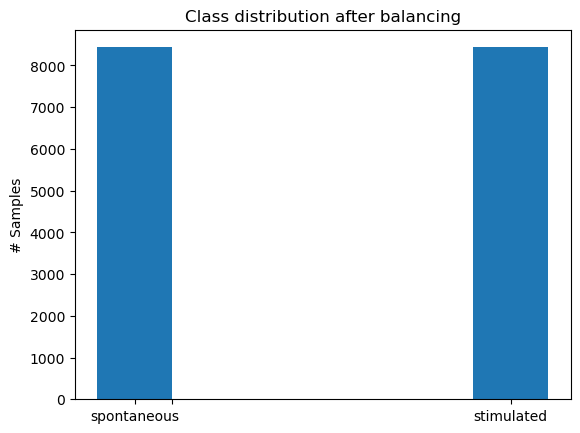

In [8]:
plt.hist(y_res, bins=[-0.1, 0.1, 0.9,1.1])
plt.xticks([0,0.1,1.0],['spontaneous', '', 'stimulated'])
plt.ylabel("# Samples")
plt.title("Class distribution after balancing")
plt.show()

In [9]:
"""
2.1)  DATASET SPLIT INTO TRAINING AND TESTING 60/40
"""
# after the dataset is loaded we built separate datasets for training and testing 
# in this case we are using 60% training and 40% testing

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.4, random_state=0)


# data standarization to avoid issues of scaling in dimensionality reduction 

scaler_train = preprocessing.StandardScaler().fit(X_train)
scaler_test = preprocessing.StandardScaler().fit(X_test)

X_train = scaler_train.transform(X_train)
X_test = scaler_test.transform(X_test)

In [10]:
activity = X_train.mean(axis=1)
acitivity_spont = activity[y_train == 0]
acitivity_stim = activity[y_train == 1]

act_spont_neuron = acitivity_spont 
act_stim_neuron = acitivity_stim 

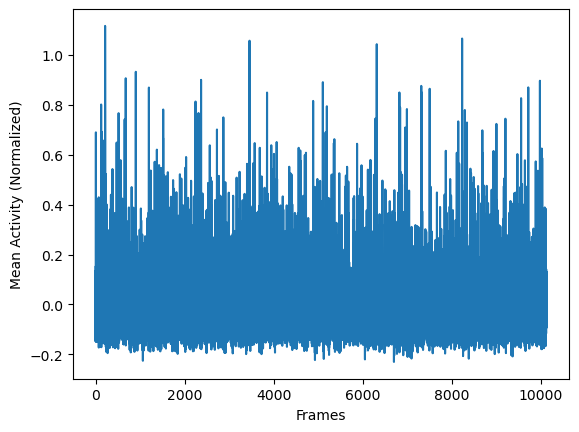

In [11]:
plt.plot(activity)
plt.xlabel("Frames")
plt.ylabel("Mean Activity (Normalized)")
plt.show()

## 2) Naive Bayes Classifier

The Naive Bayes classifier is very simple because I'm using only a 1-gram model: the mean activity of the current frame. I'm mostly using this model as a baseline for its simplicity. Basically, I determine the conditional distributions of the two classes and then use Bayes' theorem to determine the posterior distributions of the classes given the observed activity.

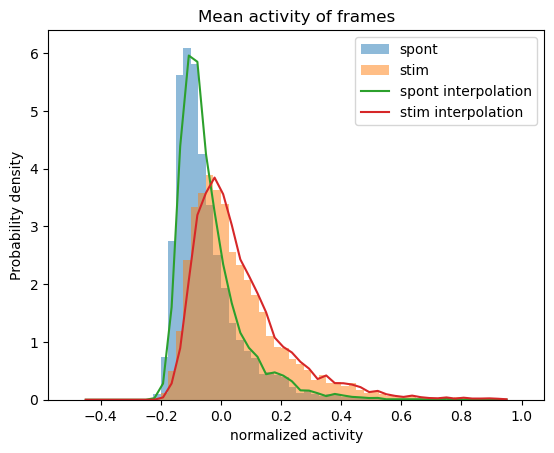

In [12]:
entries_spont, bin_edges_spont, patches_spont = plt.hist(act_spont_neuron, bins=60, range=(-0.5,1) ,alpha = 0.5, label = "spont", density = True)
entries_stim, bin_edges_stim, patches_stim = plt.hist(act_stim_neuron,  bins=60, range=(-0.5,1), alpha = 0.5, label = "stim", density = True)

x_interpolation = np.linspace(-0.45,0.95)

interp_spont = interpolate.interp1d(bin_edges_spont[1:], entries_spont)
interp_stim = interpolate.interp1d(bin_edges_stim[1:], entries_stim)

plt.plot(x_interpolation, interp_spont(x_interpolation), label = "spont interpolation")
plt.plot(x_interpolation, interp_stim(x_interpolation), label = "stim interpolation")


plt.xlabel("normalized activity")
plt.ylabel("Probability density")
plt.title("Mean activity of frames")
plt.legend()
plt.show()

In [13]:
def bayes_prob_spont(x):
    p_spont = interp_spont(x)/(interp_spont(x) + interp_stim(x) + 1e-6) # small constant added to avoid zero division
    return p_spont

def bayes_prob_stim(x):
    return 1 - bayes_prob_spont(x)

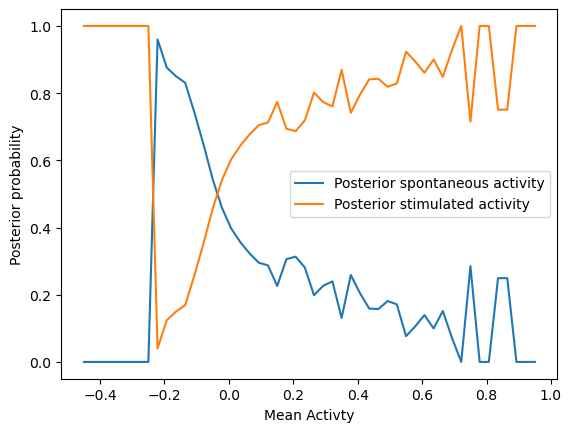

In [14]:

x_bayes = np.linspace(-0.45,0.95)

plt.plot(x_bayes, bayes_prob_spont(x_bayes), label = "Posterior spontaneous activity")
plt.plot(x_bayes, bayes_prob_stim(x_bayes), label = "Posterior stimulated activity")
plt.xlabel("Mean Activty")
plt.ylabel("Posterior probability")
plt.legend()
plt.show()

In [15]:
activity_test = X_test.mean(axis=1)
activity_test_not_outliers = activity_test < 3*activity_test.std()
activity_test_3_sigma = activity_test[activity_test_not_outliers]
y_test_3_sigma = y_test[activity_test_not_outliers]


probs_bayes_test = np.zeros((len(activity_test_3_sigma),2))
for i in range(len(activity_test_3_sigma)):
    probs_bayes_test[i,0] = bayes_prob_spont(activity_test_3_sigma[i])
    probs_bayes_test[i,1] = bayes_prob_stim(activity_test_3_sigma[i])


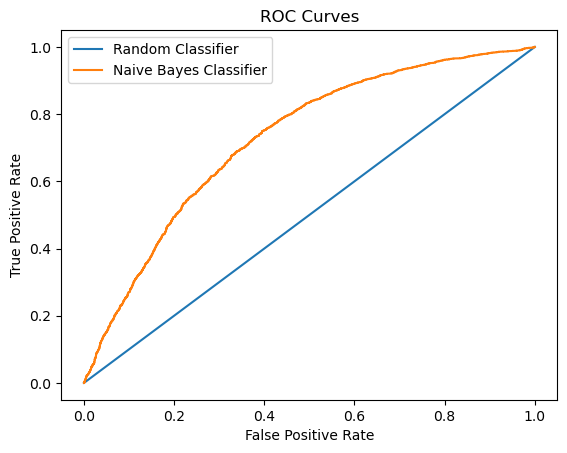

In [16]:
fpr_bayes, tpr_bayes, _ = sklearn.metrics.roc_curve(y_test_3_sigma, probs_bayes_test[:, 1], pos_label=1, drop_intermediate=False)
plt.plot(fpr_bayes, fpr_bayes, label = "Random Classifier")
plt.plot(fpr_bayes, tpr_bayes, label = "Naive Bayes Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()

## 3) Dimensionality Reduction

The training data has $N = 13101$ features, but most of the variance likely lies on a lower-dimensional manifold. We can take advantage of this by finding a coordinate transformation that maps the training data to this low-dimensional space. This not only reduces the number of features but also improves the quality of the features by capturing the underlying structure of the data. 

To achieve this, we use **Principal Component Analysis (PCA)**. The algorithm finds a new coordinate system by diagonalizing the covariance matrix. First, we standardize the data:

$$
X_{\text{norm}} \rightarrow X - \mu
$$

So the covariance matrix can be written as:

$$
C = \frac{1}{N}X_{\text{norm}}^T X_{\text{norm}}
$$

The idea of PCA is to find a change of basis $P$ such that $P C P^T$ is diagonal, the data in the new coordianates can be found by applying the map:

$$
T = PX
$$

and then truncanting the trnasformation up to some dimension $L < N$:

$$
T_L = P_L X
$$

The column vectors of the transformation are the new basis, and the variance associated with each eigenvector is associated with its eigenvalue

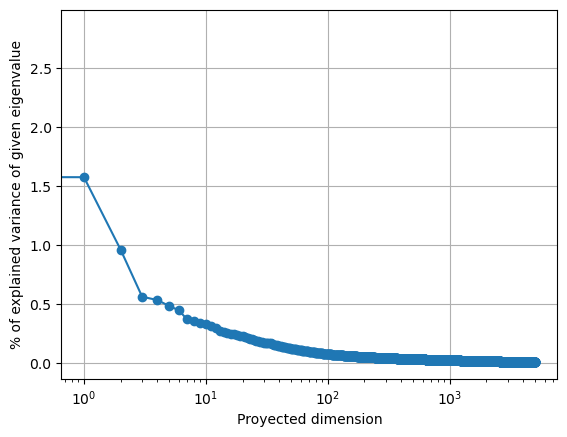

In [17]:
pca = PCA(n_components=5000)
pca.fit(X_train)
plt.plot(100*pca.explained_variance_ratio_, '-o')
plt.xscale("log")
plt.xlabel("Proyected dimension")
plt.ylabel("% of explained variance of given eigenvalue")
plt.grid()
plt.show()

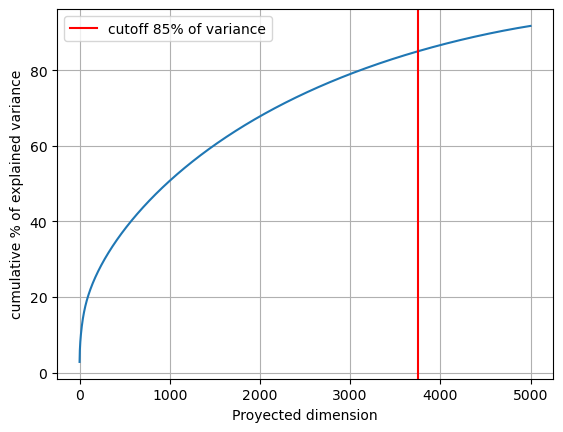

In [18]:
# Calculate the cumulative explained variance
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Determine the number of components to keep for 85% variance explained
n_components = np.argmax(cumulative_variance_ratio >= 0.85) + 1


plt.plot(100*cumulative_variance_ratio)
plt.axvline(x=n_components, color = "red", label = "cutoff 85% of variance")
plt.xlabel("Proyected dimension")
plt.ylabel("cumulative % of explained variance")
plt.legend()
plt.grid()
plt.show()

In [19]:
# Apply PCA transformation to reduce dimensionality
X_train_pca = pca.transform(X_train)[:, :n_components]  # Transform training data using PCA and keep the first n_components
X_test_pca  = pca.transform(X_test)[:, :n_components]   # Transform test data using PCA and keep the first n_components

#Standardize the data using StandardScaler
scaler_train = preprocessing.StandardScaler().fit(X_train_pca)  # Fit scaler on training data
scaler_test = preprocessing.StandardScaler().fit(X_test_pca)    # Fit scaler on test data

# Transform the data using the trained scalers
X_train_pca = scaler_train.transform(X_train_pca)  # Transform training data
X_test_pca = scaler_test.transform(X_test_pca)     # Transform test data


## 4) Logistic Regression

The problems of binary classification, in this case (spontaenous or stimulated) can be easly formulated in terms of a logistic regression, this model asumes that the probability of finding a positive case in the data $x$ given the parameters $w$ is:

$$
y_n = p(y=1|w,x_n) = \frac{1}{1 + \exp{w^T x_n}}
$$

the parameters $w$ are usually fouond using MLE (maximum likelihood estimation) **which is equivalent to minimizing the cross-entropy loss** between the observed values $t_n$ and the predicted values $y_n$:

$$
\text{Cross Entropy}(w) = -\sum_{n=1}^N (t_n \log{(1-y_n)} + (1-t_n)\log{(1-y_n)})
$$

In [20]:
def get_logistic_model(n_keep_pca, X_train, y_train, X_test):
    """
    Train a logistic regression model and make predictions using Principal Component Analysis (PCA) for feature reduction.
    
    Parameters:
        n_keep_pca (int): Number of principal components to retain.
        X_train (array-like): Training data features.
        y_train (array-like): Training data labels.
        X_test (array-like): Test data features.
    
    Returns:
        tuple: A tuple containing the trained logistic regression model, predictions, and prediction probabilities.
    """
    
    """ Second PCA reduction:
    
    Before fitting the logistic regression model  we reestrict again the number of dimensions of the problem and use
    this dimension as hyper-parameter of the model. In this way we avoid fitting features that are highly correlated
    (colinearity). 
    
    """
    
    # Apply PCA for feature reduction
    X_train_pca = X_train[:, :n_keep_pca]
    X_test_pca  = X_test[:, :n_keep_pca]
    
    # Train logistic regression model with specified parameters
    # max_iter set to 300 to help reach convergence
    clf = LogisticRegression(random_state=0, max_iter=300).fit(X_train_pca, y_train)
    

    # Use the trained model to make predictions on the test set
    predictions   = clf.predict(X_test_pca)
    probabilities = clf.predict_proba(X_test_pca)

    return clf, predictions, probabilities

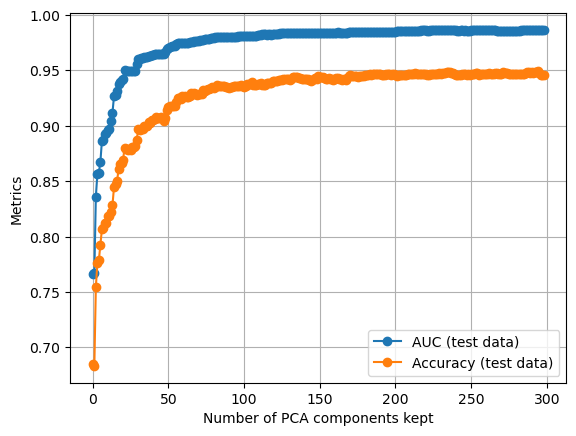

In [21]:
N_max_logistic = 300 # max number of features to keep

auc_logistic = []  # List to store AUC values
acc_logistic = []  # List to store accuracy values

# Loop through different numbers of PCA components kept
for n_i in range(1, N_max_logistic):
    # Train logistic regression model with n_i PCA components
    model, _, probs = get_logistic_model(n_i, X_train_pca, y_train, X_test_pca)
    
    # Compute ROC curve and AUC
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, probs[:, 1], pos_label=1, drop_intermediate=False)
    auc = sklearn.metrics.auc(fpr, tpr)
    
    # Compute accuracy
    acc = model.score(X_test_pca[:, :n_i], y_test)
    
    # Append AUC and accuracy to lists
    auc_logistic.append(auc)
    acc_logistic.append(acc)
    
# Plot AUC and accuracy as a function of number of PCA components kept
fig = plt.figure()
plt.plot(auc_logistic, '-o', label="AUC (test data)")
plt.plot(acc_logistic, '-o', label="Accuracy (test data)")
plt.xlabel("Number of PCA components kept")
plt.ylabel("Metrics")
plt.legend()
plt.grid()
plt.show()

In [22]:
"""
From the plot we can see that after N = 100 components the gains start to diminish pretty
fast in both metrics, so we choose N_opt = 100 for the number of features of the logistic
regression 
"""

N_opt_log = 100

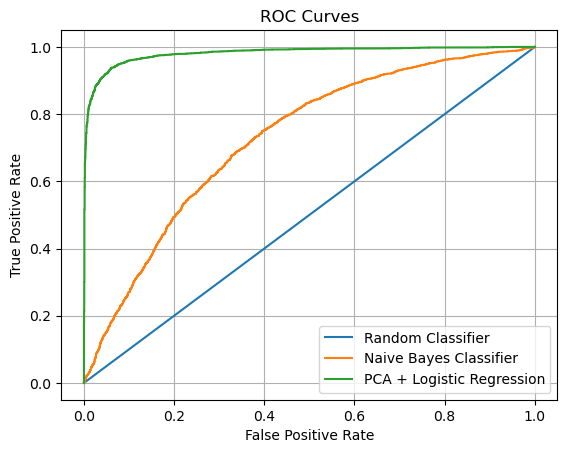

In [23]:

log_model, log_pred, log_probs = get_logistic_model(N_opt_log, X_train_pca, y_train, X_test_pca)
log_fpr, log_tpr, log_thresholds = sklearn.metrics.roc_curve(y_test, log_probs[:, 1], pos_label=1, drop_intermediate=False)


plt.plot(fpr, fpr, label = "Random Classifier")
plt.plot(fpr_bayes, tpr_bayes, label = "Naive Bayes Classifier")
plt.plot(log_fpr, log_tpr, label="PCA + Logistic Regression")  # Plot logistic regression ROC curve
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.grid()
plt.legend()
plt.show()

## 5) KNN classification

As a second approach we use a combination of PCA + K-Neareast Neighbours Classifier, **in this case we also apply a second PCA reduction prevoius to the KNN clasiffier**. 
The reason for this is the curse of dimensionality, as the number of features grows bigger the measures of distance between points as a measure of vecinity gets worse and worse. For this reason I clipped the dimenions using the first $N=100$ dimenions in the same way as I did in the Logistic Regression model.  

In [24]:

def get_knn_model(n_knn, X_train_knn, y_train_knn, X_test_knn):
    """
    Train a k-Nearest Neighbors (kNN) classifier model and make predictions.
    
    Parameters:
        n_knn (int): Number of nearest neighbors to consider.
        X_train_knn (array-like): Training data features.
        y_train_knn (array-like): Training data labels.
        X_test_knn (array-like): Test data features.
    
    Returns:
        tuple: A tuple containing the trained kNN model, predictions, and prediction probabilities.
    """
    # Initialize kNN classifier with specified number of neighbors
    neigh = KNeighborsClassifier(n_neighbors=n_knn)
    
    # Train the kNN classifier
    neigh.fit(X_train_knn, y_train_knn)

    # Use the trained model to make predictions on the test set
    predictions   = neigh.predict(X_test_knn)
    probabilities = neigh.predict_proba(X_test_knn)
    
    return neigh, predictions, probabilities

def grid_search_auc(max_knn, X_train, y_train, X_test, y_test):
    """
    Perform grid search for kNN model using Area Under Curve (AUC) as the evaluation metric.
    
    Parameters:
        max_knn (int): Maximum number of neighbors to consider in the grid search.
        X_train (array-like): Training data features.
        y_train (array-like): Training data labels.
        X_test (array-like): Test data features.
        y_test (array-like): Test data labels.
    
    Returns:
        tuple: A tuple containing arrays of AUC values and accuracy values for different number of neighbors.
    """
    # Initialize arrays to store AUC and accuracy values for different k values
    acc_vals = np.zeros(max_knn)
    auc_vals = np.zeros(max_knn)

    # Perform grid search for different number of neighbors
    for n_knn in range(1, max_knn):
        
        # Train kNN model and make predictions
        model, _, probs = get_knn_model(n_knn, X_train, y_train, X_test)
        
        # Compute ROC curve and AUC
        fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, probs[:, 1], pos_label=1, drop_intermediate=False)
        auc = sklearn.metrics.auc(fpr, tpr)
        
        # Store AUC and accuracy values
        auc_vals[n_knn] = auc
        acc_vals[n_knn] = model.score(X_test, y_test)
            
    return auc_vals, acc_vals


In [25]:
auc_vals_knn, acc_vals_knn = grid_search_auc(15,X_train_pca[:, :100], y_train, X_test_pca[:,:100], y_test) 
opt_N_knn = np.argwhere(acc_vals_knn==acc_vals_knn.max())[0][0]

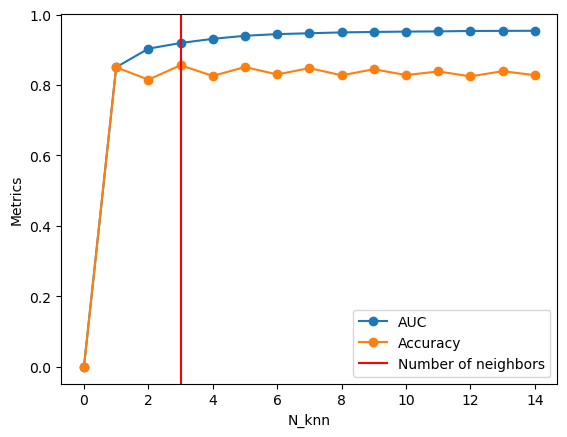

In [26]:
plt.plot(auc_vals_knn, "-o", label = "AUC")
plt.plot(acc_vals_knn, "-o", label = "Accuracy")
plt.axvline(x=opt_N_knn, color = "red", label = "Number of neighbors")
plt.ylabel("Metrics")
plt.xlabel("N_knn")
#plt.title("AUC values")
plt.legend()
plt.show()

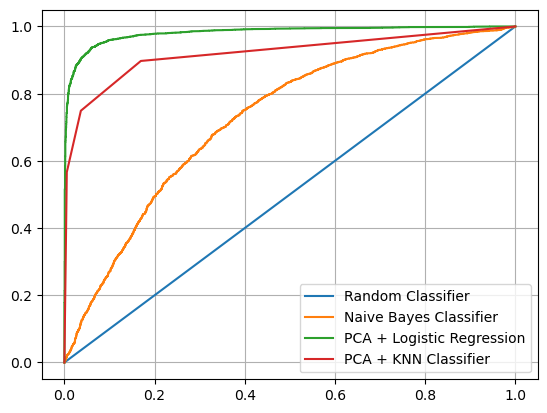

In [27]:
model, pred, probs = get_knn_model(opt_N_knn,X_train_pca[:, :N_opt_log], y_train, X_test_pca[:, :N_opt_log])
fpr_knn, tpr_knn, _ = sklearn.metrics.roc_curve(y_test, probs[:, 1], pos_label=1, drop_intermediate=False)
auc_optim_knn =  sklearn.metrics.auc(fpr, tpr)

fig = plt.figure()

plt.plot(fpr, fpr, label = "Random Classifier")
plt.plot(fpr_bayes, tpr_bayes, label = "Naive Bayes Classifier")
plt.plot(log_fpr, log_tpr, label="PCA + Logistic Regression")  # Plot logistic regression ROC curve
plt.plot(fpr_knn, tpr_knn, label="PCA + KNN Classifier")  # Plot logistic regression ROC curve

#plt.title("ROC curve of the best values of hyperparameters found \n N_knn = {} , AUC = {:.3f}".format(opt_N_knn, auc_optim_knn))
plt.grid()
plt.legend()
plt.show()

## 6) Deep Neural Network

As a final model for prediction i'm gonna use a two hidden layer neural network with ReLu activations with softmax layer for classification. For the hyper-parameter tuning I only change the learning rate and the number of neurons in the first hidden layer. We can think the network as 2 non-linear dimensionality reductions + a classification layer 

In [28]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.utils.data as data_utils

In [29]:

class NeuralNetwork(nn.Module):
    """
    Neural network with customizable hidden layer sizes.
    
    Parameters:
        N1_hidden (int): Number of neurons in the first hidden layer.
        N2_hidden (int): Number of neurons in the second hidden layer.
    """
    def __init__(self, N1_hidden, N2_hidden):
        super().__init__()
        
        # Initialize the number of neurons in the hidden layers
        self.N1 = N1_hidden
        self.N2 = N2_hidden
        
        # Define the sequential layers of the neural network
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(N_neurons, self.N1),  # Input layer to first hidden layer
            nn.ReLU(),                      # ReLU activation function
            nn.Linear(self.N1, self.N2),    # First hidden layer to second hidden layer
            nn.ReLU(),                      # ReLU activation function
            nn.Linear(self.N2, 2)           # Second hidden layer to output layer (2 classes)
        )

    def forward(self, x):
        """
        Forward pass of the neural network.
        
        Parameters:
            x (torch.Tensor): Input data.
        
        Returns:
            torch.Tensor: Logits obtained after passing through the neural network layers.
        """
        # Convert input data to tensor
        x = torch.tensor(x)
        
        # Pass input through the sequential layers
        logits = self.linear_relu_stack(x)
        
        return logits


In [30]:

batch_size = 64

# Create TensorDataset objects for training and testing data
train_dataset = data_utils.TensorDataset(torch.tensor(X_train).requires_grad_(True),  # Convert training data to tensor
                                         torch.LongTensor(y_train))                # Convert training labels to tensor
test_dataset = data_utils.TensorDataset(torch.tensor(X_test).requires_grad_(True),    # Convert test data to tensor
                                        torch.LongTensor(y_test))                  # Convert test labels to tensor

# Create DataLoader objects for training and testing datasets
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)  # DataLoader for training dataset
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)    # DataLoader for testing dataset


In [31]:
import torch
import torch.nn as nn

def train_loop(dataloader, model, loss_fn, optimizer, loss_history):
    """
    Function to perform training loop for one epoch.
    
    Parameters:
        dataloader (torch.utils.data.DataLoader): DataLoader object containing the training data.
        model (torch.nn.Module): Neural network model to be trained.
        loss_fn: Loss function used for training.
        optimizer: Optimizer used for updating the model parameters.
        loss_history (dict): Dictionary to store the training loss history.
    """
    size = len(dataloader.dataset)
    model.train()  # Set model to training mode
    
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)  # Forward pass
        loss = loss_fn(pred, y)  # Compute loss
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Record the training loss after each epoch
    loss_history["train"].append(loss.item())

def test_loop(dataloader, model, loss_fn, loss_history):
    """
    Function to perform testing loop to evaluate the model's performance.
    
    Parameters:
        dataloader (torch.utils.data.DataLoader): DataLoader object containing the test data.
        model (torch.nn.Module): Trained neural network model.
        loss_fn: Loss function used for testing.
        loss_history (dict): Dictionary to store the test loss history.
    """
    model.eval()  # Set model to evaluation mode
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    
    # Disable gradient calculation during testing
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size 
    
    # Record the test loss after each epoch
    loss_history["test"].append(test_loss)

def train_network(epochs, model, train_dataloader, test_dataloader, verbose=False):
    """
    Function to train the neural network model for a specified number of epochs.
    
    Parameters:
        epochs (int): Number of epochs for training.
        model (torch.nn.Module): Neural network model to be trained.
        train_dataloader (torch.utils.data.DataLoader): DataLoader object containing the training data.
        test_dataloader (torch.utils.data.DataLoader): DataLoader object containing the test data.
        verbose (bool): If True, print training progress for each epoch.
    
    Returns:
        dict: Dictionary containing the training and test loss history.
    """
    loss_history = {"train": [], "test": []}
    
    # Initialize the loss function and optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    for t in range(epochs):
        if verbose:
            print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_dataloader, model, loss_fn, optimizer, loss_history)
        test_loop(test_dataloader, model, loss_fn, loss_history)
    
    if verbose:
        print("Training Done!")
        
    return loss_history


In [32]:
# list of parameter for tuning
learning_rate_list = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2]
N1_list = [50, 100, 200, 300]

# these paramters are kept fixed in this tuning

N2 = 50
epochs = 40

results = {}

for N1 in N1_list:
    
    results[N1] = {}
    
    for learning_rate in learning_rate_list:
        
        print(f"Training N1: {N1} lr: {learning_rate}")
        # hyper-parameters
        model = NeuralNetwork(N1,N2)
        
        loss_history = train_network(epochs, model, train_dataloader, test_dataloader)
        results[N1][learning_rate] = (loss_history, model)
        

Training N1: 50 lr: 0.0001


/tmp/ipykernel_796712/2626372280.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


Training N1: 50 lr: 0.0005
Training N1: 50 lr: 0.001
Training N1: 50 lr: 0.005
Training N1: 50 lr: 0.01
Training N1: 100 lr: 0.0001
Training N1: 100 lr: 0.0005
Training N1: 100 lr: 0.001
Training N1: 100 lr: 0.005
Training N1: 100 lr: 0.01
Training N1: 200 lr: 0.0001
Training N1: 200 lr: 0.0005
Training N1: 200 lr: 0.001
Training N1: 200 lr: 0.005
Training N1: 200 lr: 0.01
Training N1: 300 lr: 0.0001
Training N1: 300 lr: 0.0005
Training N1: 300 lr: 0.001
Training N1: 300 lr: 0.005
Training N1: 300 lr: 0.01


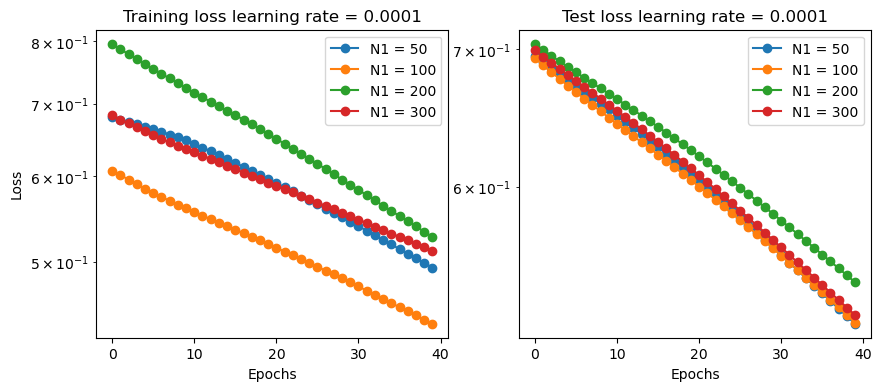

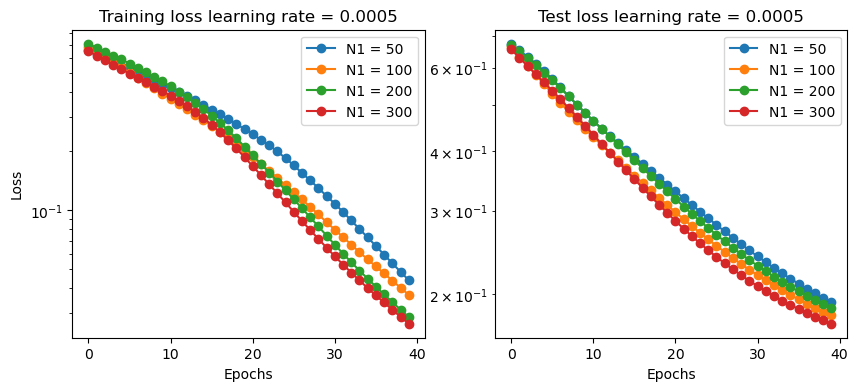

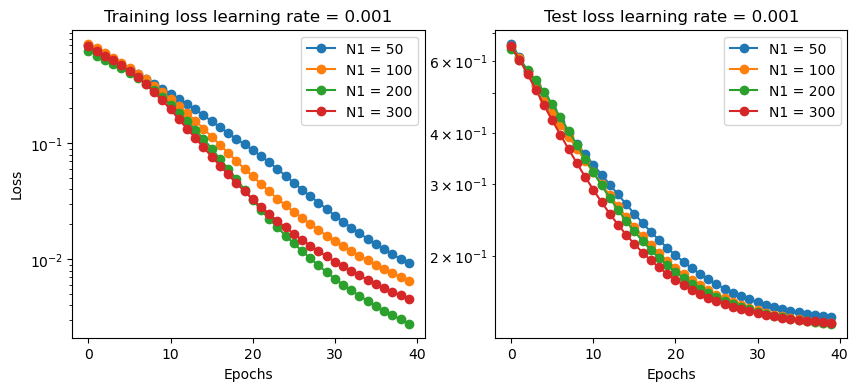

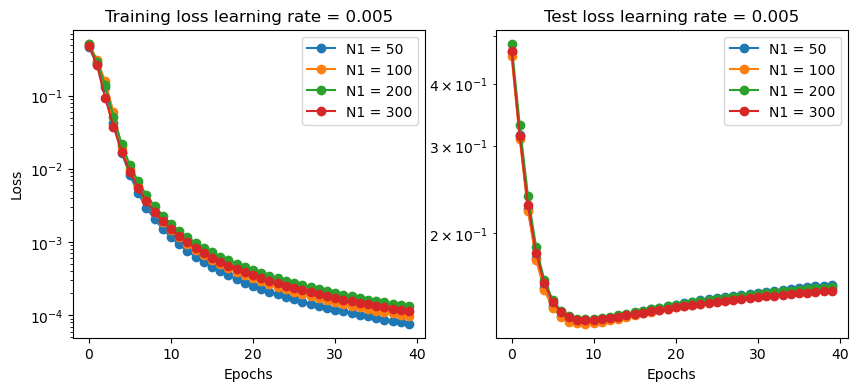

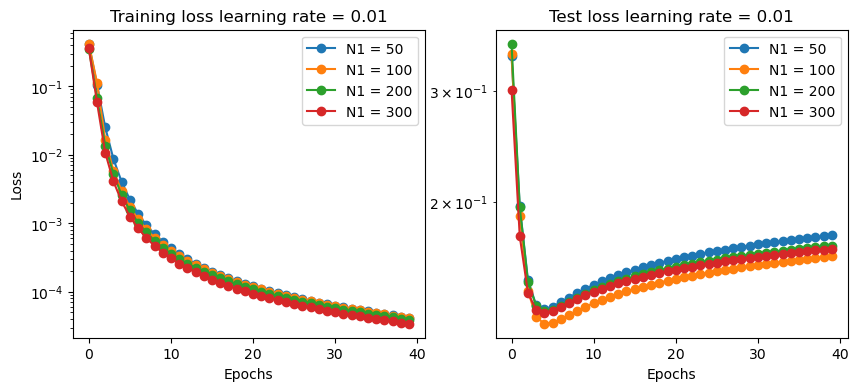

In [33]:
def plot_loss_data(lr):

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4))

    for N1 in N1_list:


        ax1.plot(results[N1][lr][0]["train"], "-o", label = f"N1 = {N1}")
        ax2.plot(results[N1][lr][0]["test"], "-o", label =  f"N1 = {N1}")

        #plt.plot(loss_history["test"], "-o",  label = "Test Loss")
        ax1.set_xlabel("Epochs")
        ax1.set_ylabel("Loss")
        ax1.set_yscale("log")
        ax1.grid()
        ax1.legend()
        ax1.set_title(f"Training loss learning rate = {lr}")

        ax2.set_xlabel("Epochs")
        ax2.set_yscale("log")
        ax2.legend()
        ax2.grid()
        ax2.set_title(f"Test loss learning rate = {lr}")
    
    plt.show()

for lr in learning_rate_list:
    plot_loss_data(lr)

In [34]:
best_model = results[100][0.001][1]
best_model

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=13101, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=2, bias=True)
  )
)

In [35]:
m = nn.Softmax(dim=1)
probs = m(torch.tensor(best_model(X_test)))

/tmp/ipykernel_796712/419200454.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  probs = m(torch.tensor(best_model(X_test)))


In [36]:
nn_fpr, nn_tpr, nn_thresholds = sklearn.metrics.roc_curve(y_test, probs[:, 1], pos_label=1, drop_intermediate=False)

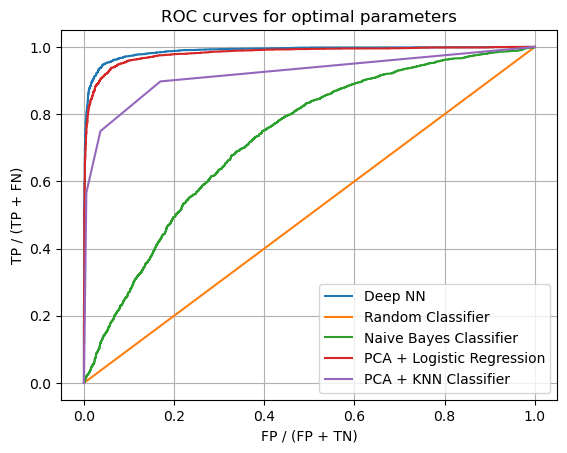

In [37]:
plt.plot(nn_fpr, nn_tpr, label = "Deep NN")
plt.plot(fpr, fpr, label = "Random Classifier")
plt.plot(fpr_bayes, tpr_bayes, label = "Naive Bayes Classifier")
plt.plot(log_fpr, log_tpr, label="PCA + Logistic Regression")  # Plot logistic regression ROC curve
plt.plot(fpr_knn, tpr_knn, label="PCA + KNN Classifier")  # Plot logistic regression ROC curve

plt.xlabel("FP / (FP + TN)")
plt.ylabel("TP / (TP + FN)")
plt.title("ROC curves for optimal parameters")
plt.legend()
plt.grid()
plt.savefig("images/roc_curves_final.png")

## Conclusions

Observing the final ROC curves, it is clear that the Deep Neural Network (DNN) model only marginally outperforms the PCA + Logistic Regression model. It is probable that with better hyper-parameter tuning, the neural network would have better performance. However, the logistic model required almost no tuning and has a quicker inference time.

The fact that logistic regression performs so well is consistent with findings in Stringer's original paper. They demonstrated that the datasets were linearly separable in space and that the gains from the nonlinear dimensionality reduction performed by the neural network are only marginal. Therefore, in a balance between performance and simplicity, I would recommend logistic regression.

## Further Improvements

The limitation of this analysis is that it is only valid for a single mouse. The database contains datasets from many mice where similar experiments were conducted but with different numbers of neurons. One improvement could be the construction of a dataset of "activation images" using information from the spatial coordinates of the neurons. This way, images of the visual cortex of other mice could be taken, and the model's performance could be tested on truly independent data.
